# Benchmarking spot counting using Vision Language Models

There are some vision language models such as [moondream](https://huggingface.co/vikhyatk/moondream2) which are capable of counting objects in images by pointing at them. The model generates a list of point coordinates corresponding to locations in the image where prompted objects are. While the model is trained for natural images, it can be used to count bright blobs in dark images, too. This indicates that such models might be useful for microscopy image analysis. In this notebook we will benchmark how well it performs, first on an actual microscopy image of nuclei and furthermore on synthetic images the look similar.

Installation (Windows):
* Download vips-dev-w64-all-8.16.1.zip from [here](https://github.com/libvips/build-win64-mxe/releases/tag/v8.16.1), unzip it, and add its subfolder `bin` to the PATH environment variable.
* `pip install einops pyvips`

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
from image_utilities import numpy_to_bytestream, extract_json, generate_spots
from tqdm import tqdm
import stackview

model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-01-09",
    trust_remote_code=True,
    # Comment to run on CPU. To use the GPU, you need about 5 GB of GPU Memory.
    device_map={"": "cuda"}
)

## Human mitosis


StackViewNDArray([[ 8,  8,  8, ..., 10,  9,  9],
                  [ 8,  8,  7, ..., 10, 11, 10],
                  [ 9,  8,  8, ...,  9, 10,  9],
                  ...,
                  [ 9,  8,  9, ...,  9,  9,  8],
                  [ 9,  8,  8, ...,  9,  9,  9],
                  [ 8,  8,  9, ..., 10,  9,  9]], dtype=uint8)
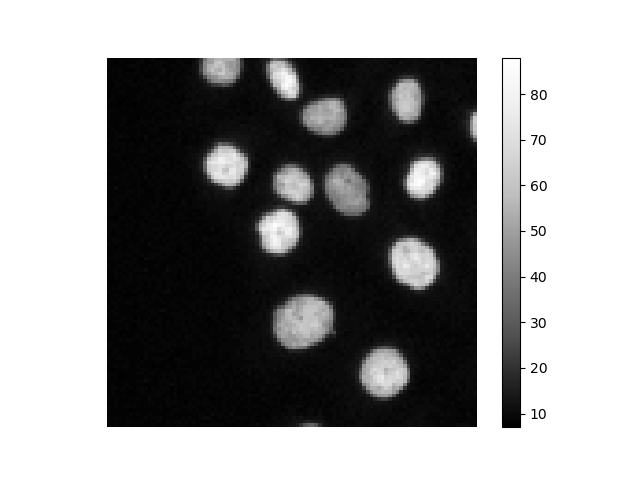
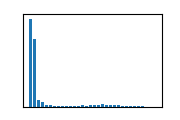

In [2]:
import stackview
from skimage import data
import numpy as np

# Load the human mitosis dataset
image = data.human_mitosis()[:100, :100]

# Display the image
stackview.insight(image)

In [3]:
pil_image = Image.fromarray(image)

encoded_image = model.encode_image(pil_image)

In [4]:
# Pointing
print("\nPointing: 'bright spot'")
points = model.point(encoded_image, "Mark the bright dots")["points"]
print(f"Found {len(points)} bright spot(s)")


Pointing: 'bright spot'
Found 14 bright spot(s)


In [5]:

box_half_size = 5 / image.shape[0]
bb = [{'x':p['x']-box_half_size, 'y':p['y']-box_half_size, 'width':2*box_half_size, 'height':2*box_half_size } for p in points]

StackViewNDArray([[[ 3,  3,  3],
                   [ 3,  3,  3],
                   [ 3,  3,  3],
                   ...,
                   [ 9,  9,  9],
                   [ 6,  6,  6],
                   [ 6,  6,  6]],

                  [[ 3,  3,  3],
                   [ 3,  3,  3],
                   [ 0,  0,  0],
                   ...,
                   [ 9,  9,  9],
                   [12, 12, 12],
                   [ 9,  9,  9]],

                  [[ 6,  6,  6],
                   [ 3,  3,  3],
                   [ 3,  3,  3],
                   ...,
                   [ 6,  6,  6],
                   [ 9,  9,  9],
                   [ 6,  6,  6]],

                  ...,

                  [[ 6,  6,  6],
                   [ 3,  3,  3],
                   [ 6,  6,  6],
                   ...,
                   [ 6,  6,  6],
                   [ 6,  6,  6],
                   [ 3,  3,  3]],

                  [[ 6,  6,  6],
                   [ 3,  3,  3],
                   [ 3,  3,  3],
                   ...,
                   [ 6,  6,  6],
                   [ 6,  6,  6],
                   [ 6,  6,  6]],

                  [[ 3,  3,  3],
                   [ 3,  3,  3],
                   [ 6,  6,  6],
                   ...,
                   [ 9,  9,  9],
                   [ 6,  6,  6],
                   [ 6,  6,  6]]], dtype=uint8)
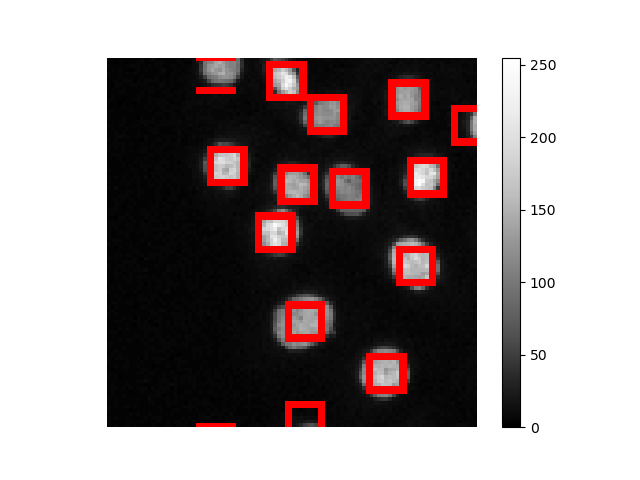
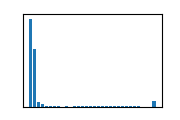

In [6]:
stackview.add_bounding_boxes(image, bb)

In [ ]:
counts_mean = []
counts_std = []
counts_gt = []
images = []

for n in tqdm(range(1, 72, 1)):
    counts_gt.append(n)

    coords, image = generate_spots(n=n, sigma=5)
    pil_image = Image.fromarray(image)
    encoded_image = model.encode_image(pil_image)
    
    # Run model.point 10 times and collect results
    run_counts = []
    first_run_points = None
    
    for _ in range(10):
        points = model.point(encoded_image, "Mark the bright dots")["points"]
        run_counts.append(len(points))
        
        # Store points from first run for visualization
        if first_run_points is None:
            first_run_points = points
    
    # Calculate mean and standard deviation
    counts_mean.append(np.mean(run_counts))
    counts_std.append(np.std(run_counts))
    
    # Use points from first run for visualization
    box_half_size = 5 / image.shape[0]
    bb = [{'x':p['x']-box_half_size, 'y':p['y']-box_half_size, 'width':2*box_half_size, 'height':2*box_half_size } for p in first_run_points]
    images.append(stackview.add_bounding_boxes(image, bb))

 55%|█████████████████████████████████████████████                                     | 39/71 [15:52<21:23, 40.11s/it]

In [ ]:
# Create a figure
plt.figure(figsize=(10, 8))

# Create x values for plotting (use counts_gt)
x = np.array(counts_gt)

# Plot counts_mean vs counts_gt with error bars from counts_std
plt.errorbar(x, counts_mean, yerr=counts_std, fmt='o', capsize=5, 
             markersize=6, label='Detected Points (mean ± std)')

# Add diagonal line (y=x) representing perfect detection
max_val = max(max(x), max(counts_mean) + max(counts_std))
plt.plot([0, max_val], [0, max_val], 'k--', label='Perfect Detection')

# Add labels and title
plt.xlabel('Ground Truth (Number of Points)', fontsize=12)
plt.ylabel('Detected Points', fontsize=12)
plt.title('Point Detection Performance with Uncertainty', fontsize=14)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Set equal aspect ratio to make the plot square
plt.axis('equal')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
stackview.animate(images, frame_delay_ms=500)

In [ ]:
# next:
# https://github.com/haesleinhuepf/git-bob-playground/issues/268#issuecomment-2746190367